In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tf_bodypix opencv-python tfjs_graph_converter matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path="/content/drive/Shareddrives/576project"
os.chdir(path)

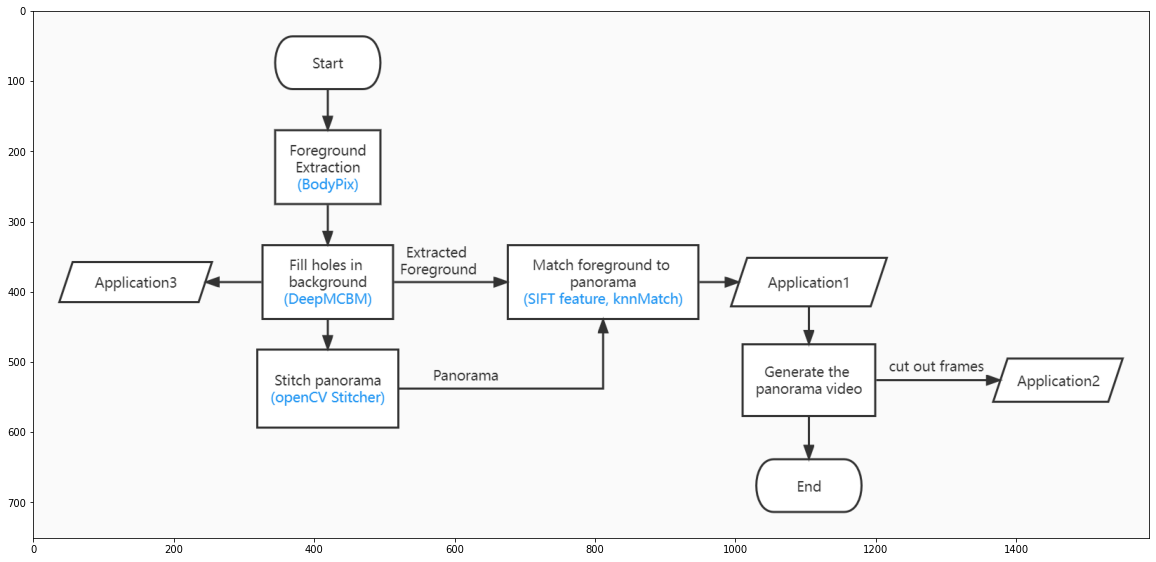

In [ ]:
from matplotlib import pyplot as plt
import cv2
flow = cv2.imread("FlowChart.jpg")
plt.figure(figsize = (20,30))
plt.imshow(cv2.cvtColor(flow, cv2.COLOR_BGR2RGB))

In [ ]:
import tensorflow as tf
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab import drive
import os
from os.path import isfile, join


Application3 = "application3"
outputBackgroundPath = "OutputBackground"
outputForegroundPath = "OutputForeground"

In [ ]:
load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))
bodypix_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))

filename = "test1.mp4"
# get vid cap device
cap = cv2.VideoCapture(filename)
i = 0
# loop through frame
fg = []
bg = []
while cap.isOpened():
  try:
    ret, frame = cap.read()
    img = frame
    
    # BodyPix Detections
    result = bodypix_model.predict_single(frame)
    mask = result.get_mask(threshold=0.3).numpy().astype(np.uint8)
    masked_image = cv2.bitwise_and(frame, frame, mask=mask)

    # process background
    neg = np.add(mask, -1)
    inverse = np.where(neg==-1, 1, neg).astype(np.uint8)
    masked_background = cv2.bitwise_and(img, img, mask=inverse)
    masked_background = np.dstack((masked_background, inverse * 255))
    cv2.imwrite(outputBackgroundPath + '/bg'+ str(i).zfill(4) + '.png', masked_background)
    bg.append(masked_background)
    # final = cv2.add(masked_image, masked_background)
    
    # Show result to user on desktop
    masked_image = np.dstack((masked_image, mask * 255))
    cv2.imwrite(outputForegroundPath + '/BodyPix'+ str(i).zfill(4) + '.png', masked_image)
    fg.append(masked_image)
    i += 1

  except:  # Break loop outcome
    print("done")
    break

cap.release() # Releases webcam or capture device
cv2.destroyAllWindows() # Closes imshow frames

done


In [ ]:
# Foreground Video Generation
import cv2
import glob
filename = glob.glob("OutputForeground/*.png")
foregeoundFrame = [cv2.imread(each) for each in filename]

file = cv2.VideoWriter('test1_fg.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (foregeoundFrame[0].shape[1], foregeoundFrame[0].shape[0]))
for frame in foregeoundFrame:
    file.write(frame)
file.release()
plt.imshow(cv2.cvtColor(foregeoundFrame[0], cv2.COLOR_BGR2RGB))

In [ ]:
# Application3 fill blank areas of foreground objects with estimated background (generated by deep learning)
estimatedBackgroundPath = "BackgroundEstimation"
panoFrame = []
i = 0
for outputBg in bg:
    estimatedFilename = "frame" + str(i).zfill(6) + ".png"
    estimatedBg = cv2.imread(os.path.join(estimatedBackgroundPath, estimatedFilename), cv2.IMREAD_UNCHANGED)
    height, width, _ = outputBg.shape
    estimatedBgResized = cv2.resize(estimatedBg, (width, height))
    outputBg = (outputBg[:,:,[3]] == 0) * estimatedBgResized + (outputBg[:,:,[3]] != 0) * outputBg
    
    resultPath = os.path.join(Application3, str(i).zfill(6) + ".png")
    cv2.imwrite(resultPath, outputBg)

    i += 1
# Output mp4 files
file = cv2.VideoWriter('test1_3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), cap.get(cv2.CAP_PROP_FPS), (outputBg[0].shape[1], outputBg[0].shape[0]))
for frame in outputBg:
    file.write(frame)
file.release()
plt.imshow(cv2.cvtColor(outputBg[0], cv2.COLOR_BGR2RGB))

135


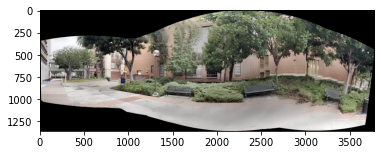

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
filename = glob.glob("application3/*.png")
panoFrame = [cv2.imread(each) for each in filename]
panoFrame = panoFrame[::3]
print(len(panoFrame))

stitcher = cv2.Stitcher_create(mode = 0)
ret, panorama = stitcher.stitch(panoFrame)
if ret != cv2.STITCHER_OK:
  print('error: ', ret)

cv2.imwrite('test1_pano.png', panorama)
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import glob
class matcher:

  def __init__(self):
      #self.surf = cv2.SURF_create()
      self.sift = cv2.SIFT_create()
      FLANN_INDEX_KDTREE = 1
      index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
      search_params = dict(checks=50)
      self.flann = cv2.FlannBasedMatcher(index_params, search_params)

  def match(self, i1, i2, direction=None):
      imageSet1 = self.getSIFTFeatures(i1)
      imageSet2 = self.getSIFTFeatures(i2)
      matches = self.flann.knnMatch(imageSet2['des'], imageSet1['des'], k=2)
      good = []
      for i, (m, n) in enumerate(matches):
          if m.distance < 0.7 * n.distance:
              good.append((m.trainIdx, m.queryIdx))

      if len(good) > 4:
          pointsCurrent = imageSet2['kp']
          pointsPrevious = imageSet1['kp']

          matchedPointsCurrent = np.float32(
              [pointsCurrent[i].pt for (__, i) in good])
          matchedPointsPrev = np.float32(
              [pointsPrevious[i].pt for (i, __) in good])

          H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev,
                                    cv2.RANSAC, 4)
          return H
      return None

  def getSIFTFeatures(self, im):
      gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
      kp, des = self.sift.detectAndCompute(gray, None)
      return {'kp': kp, 'des': des}
pano = cv2.imread("test1_pano.png", cv2.IMREAD_UNCHANGED)
fg = glob.glob("OutputForeground/*.png")
bg = glob.glob("application3/*.png")

m = matcher()
transformations = []
app1 = pano.copy()
frames = []

for i in tqdm(range(len(fg))):
    if i not in selected:
      continue
    backgroundImg = cv2.imread(bg[i])
    foregroundImg = cv2.imread(fg[i])
    H = m.match(pano, backgroundImg)
    if H is None:
      frames.append(frames[-1])
      transformations.append(transformations[-1])
      print("no match ", i)
      continue

    transformations.append(H)
    height, width = pano.shape[0], pano.shape[1]
    fgReg = cv2.warpPerspective(foregroundImg, H, (width, height))

    mask = cv2.inRange(fgReg, np.array([0, 0, 0]), np.array([5, 5, 5]))
    masked_img = cv2.bitwise_and(pano, pano, mask=mask)
    frame = cv2.bitwise_or(fgReg, masked_img)
    cv2.imwrite('Application1Frame/'+ str(i).zfill(4) + '.png', frame)
    frames.append(frame)

    if i % 70 == 0:
      mask = cv2.inRange(fgReg, np.array([0, 0, 0]), np.array([5, 5, 5]))
      masked_img = cv2.bitwise_and(app1, app1, mask=mask)
      app1 = cv2.bitwise_or(fgReg, masked_img)

cv2.imwrite(f"application1.jpg", app1)

100%|██████████| 404/404 [00:41<00:00,  9.75it/s]


True

In [ ]:
# Generate video for application2 to cut
import cv2
import glob

filename = glob.glob("Application1Frame/*.png")
frames = [cv2.imread(each) for each in filename]
file = cv2.VideoWriter('test1_res.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frames[0].shape[1], frames[0].shape[0]))
for frame in frames:
    file.write(frame)
file.release()

In [ ]:
# Application2
from tqdm import tqdm
import cv2
import glob

filename = glob.glob("Application1Frame/*.png")
frames = [cv2.imread(each) for each in filename]
print(len(frames))
pano = cv2.imread("test1_pano.png", cv2.IMREAD_UNCHANGED)
print(pano.shape[0], pano.shape[1])
dimension=(640, 480)
dx = -pano.shape[1] * 0.8 / len(frames)
dy = 0
halfWidth = int(0.5 * dimension[0])
halfHeight = int(0.5 * dimension[1])
new_frames = []
camera_center = [pano.shape[1] * 0.9, pano.shape[0] * 0.5]
for i in tqdm(range(len(frames))):
  frame = frames[i]
  lx, rx = int(camera_center[0] - halfWidth), int(camera_center[0] +halfWidth)
  ly, ry = int(camera_center[1] - halfHeight), int(camera_center[1] +halfHeight)
  new_frames.append(frame[ly:ry, lx:rx])
  camera_center[0] += dx
  camera_center[1] += dy

file = cv2.VideoWriter('test1_app2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (new_frames[0].shape[1], new_frames[0].shape[0]))
for frame in new_frames:
    file.write(frame)
file.release()


404
1446 3801


100%|██████████| 404/404 [00:00<00:00, 357791.14it/s]


In [ ]:
# Application3

import cv2
import glob

filename = glob.glob("BackgroundEstimation/*.png")
frames = [cv2.imread(each) for each in filename]
file = cv2.VideoWriter('test1_app3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frames[0].shape[1], frames[0].shape[0]))
for frame in frames:
    file.write(frame)
file.release()